In [250]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_default_device", jax.devices()[2])

import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel,SplitOperatorPDEModel,OperatorPDEModel,build_batched_jac_func
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp, get_gaussianRBF
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import SketchedCG_LM

import time
from jax.scipy.sparse.linalg import cg
from jax.scipy.linalg import solve,cho_factor,cho_solve

# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy.spatial import distance
from matplotlib import cm
import time
from mpl_toolkits.mplot3d import Axes3D
# from pyDOE import lhs
# #    import sobol_seq
import os
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data,
    GP_Sampler_1D_Pinned
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results
plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 12
})

## 1.5 Step method

In [251]:
# Sample m training functions as initial conditions from a GP
def get_burgers_data(gamma,n_obs, n_coll_t, n_coll_x,run):
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = 1,
                                            X = xy_pts, 
                                            smooth = gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = run
                                        )
    vec_u0_true_function = np.vectorize(u0_true_function[0])
    # def func_u0(x):
    #     u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    #     return u0
                            
    
    # Solve m Burgers' equations with IC's: u0_true_functions 
    kappa = 0.01
    alpha = 1.


    u_true_function,ut_true_function, interp,_,_ = (
    build_burgers_data(func_u0=vec_u0_true_function,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
                        )
    # Plot
    num_fine = 500
    plt.title("True initial and final")
    grid_points = jnp.linspace(0,1,num_fine)
    plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine),grid_points]).T),label = 't=0')
    plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine),grid_points]).T),label = 't=1')
    plt.legend()
    plt.show()

    # Collocation point set size
    num_grid_x = n_coll_x
    num_grid_t = n_coll_t
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    # Collocation point set

    # Get (X^m, u^m(X^m))
    num_obs = n_obs
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs,
        jax.random.PRNGKey(run),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
    plot_input_data(
        tx_obs,
        tx_all,
        u_true_function,
        tx_fine,
                )

    return tx_obs, u_obs, tx_all, tx_int, tx_fine, u_true_function, ut_true_function, interp

  0%|          | 0/10099 [00:00<?, ?it/s]

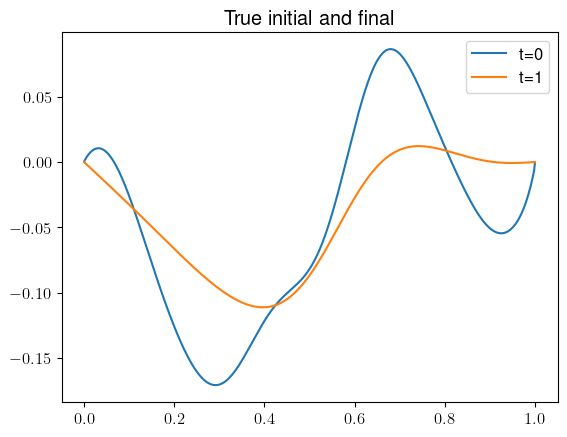

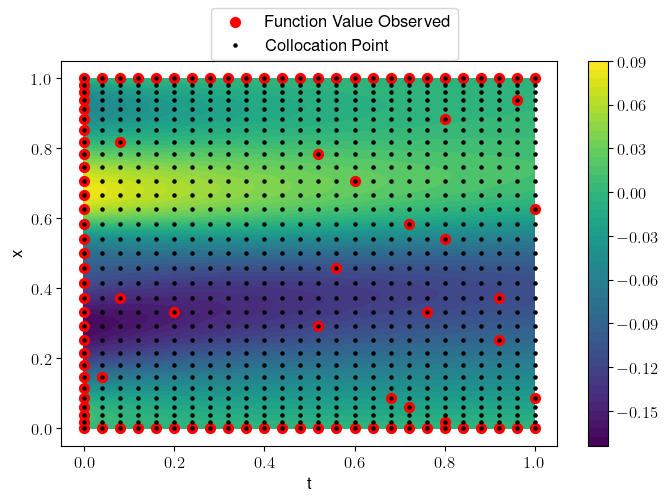

In [252]:
tx_obs, u_obs, tx_all, tx_int, tx_fine, u_true_function, ut_true_function, interp = get_burgers_data(gamma=2,n_obs=20,n_coll_t=26, n_coll_x=31, run=2)

In [253]:
# Run 1_5 step method
u_operators = (eval_k,)
feature_operators = (eval_k,dx_k,dxx_k)

# Choose u kernel
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)
print(1/(jnp.sqrt(ML_lengthscales)))
k_u = get_anisotropic_gaussianRBF(0.75,jnp.diag(log1pexp(fitted_params)))

# RKHS class for u
u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )
u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

# Choose kernel for P
k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])
P_model = OperatorModel(k_P)

[1.76720725 0.14904608]


In [254]:
# # Equation model that has u and P object
# EqnModel = SplitOperatorPDEModel(
#     P_model,
#     (u_model,),
#     (tx_obs,),
#     (u_obs,),
#     (tx_all,),
#     feature_operators,
#     rhs_operator=dt_k,
#     datafit_weight = 100,
#     jacobian_operator = build_batched_jac_func(100),
# )

In [255]:
# Equation model that has u and P object
EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

  0%|          | 0/251 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003852, Jres = 3.198, alpha = 0.08333, improvement_ratio = 1.007
Iteration 1, loss = 0.0003498, Jres = 0.1446, alpha = 0.06944, improvement_ratio = 1.046
Iteration 2, loss = 0.0003365, Jres = 0.07117, alpha = 0.05787, improvement_ratio = 1.017
Iteration 3, loss = 0.000326, Jres = 0.02145, alpha = 0.04823, improvement_ratio = 1.009
Iteration 4, loss = 0.0003162, Jres = 0.01179, alpha = 0.04019, improvement_ratio = 1.007
Iteration 5, loss = 0.0003067, Jres = 0.01165, alpha = 0.03349, improvement_ratio = 1.007
Iteration 100, loss = 1.457e-05, Jres = 9.045e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 1.221e-05, Jres = 2.23e-06, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration 0, loss = 1.1607145631664091e-05
Iteration 73 Step Failed
Iteration 82 Step Failed
Iteration 98 Step Failed
Iteration 136 Step Failed
Iteration 140 Step Failed
Iteration 158 Step Failed
Iteration 168 Step Failed
Iteration 186 Step Failed
Iteration 196 Step Failed
Iteration 213 Step Failed
Iteration 221 Step Failed
Iteration 232 Step Failed
Iteration 239 Step Failed
Iteration 243 Step Failed
Iteration 244 Step Failed
Iteration 245 Step Failed
Iteration 246 Step Failed
Iteration 249 Step Failed
Iteration 250 Step Failed
Iteration 251 Step Failed
Iteration 252 Step Failed
Iteration 253 Step Failed
Iteration 254 Step Failed
Iteration 255 Step Failed
Iteration 257 Step Failed
Iteration 258 Step Failed
Iteration 260 Step Failed
Iteration 261 Step Failed
Iteration 262 Step Failed
Iteration 263 Step Failed
Iteration 264 Step Failed
Iteration 265 Step Failed
Iteration 266 Step Failed
Iteration 267 Step Failed
Iteration 268 Step Failed
Iteration 269 Step Failed
Converged by no improvem

/tmp/ipykernel_3197328/972314455.py:21: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))


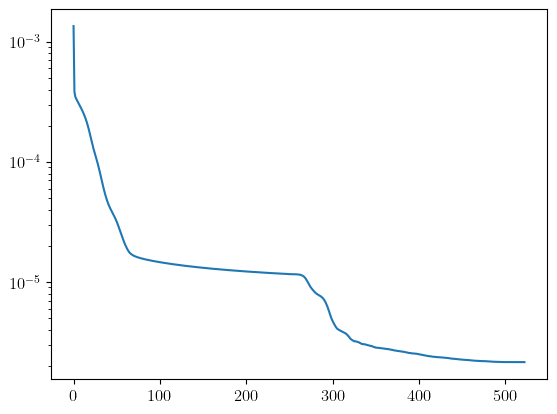

In [256]:
import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM

params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])

params,convergence_data = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 251,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 100
)

p_adjusted,refine_convergence_data = SVD_LM(
    params,EqnModel,1e-5,300,
    overall_regularization=0.)
plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))
plt.yscale('log')
plt.show()

In [257]:
# params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
# spcg_params,cg_convergence_data = SketchedCG_LM(
#     params_init.copy(),
#     EqnModel,
#     beta = 0.,
#     max_iter = 501,
#     init_alpha=0.1,
#     print_every = 100,
#     sketch_size = 200,
# )

In [258]:
# plt.plot(
#     jnp.array(cg_convergence_data['time_spent']) - jnp.array(cg_convergence_data['time_spent'])[0],
#     jnp.array(cg_convergence_data['loss_vals'])[1:],
#     label = 'SketchPCG',
#     c='black',
#     ls = '--')

# plt.yscale('log')
# plt.legend()
# plt.xlabel("Time (Seconds)")
# # plt.plot([0,150],[5e-7,5e-7])
# plt.ylabel("Loss")
# plt.show()

In [259]:
# # u_params
# u_sol = spcg_params[:u_model.num_params]
# P_sol = spcg_params[u_model.num_params:]
# # u_true 
# u_true = u_true_function(tx_fine)
# # get error
# error_u_field = get_nrmse(u_true, u_model.point_evaluate(tx_fine,u_sol))
# error_u_field

In [260]:
u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

# u_true 
u_true = u_true_function(tx_fine)
# get error
error_u_field = get_nrmse(u_true, u_model.point_evaluate(tx_fine,u_sol))
error_u_field

Array(0.01115313, dtype=float64)

In [261]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

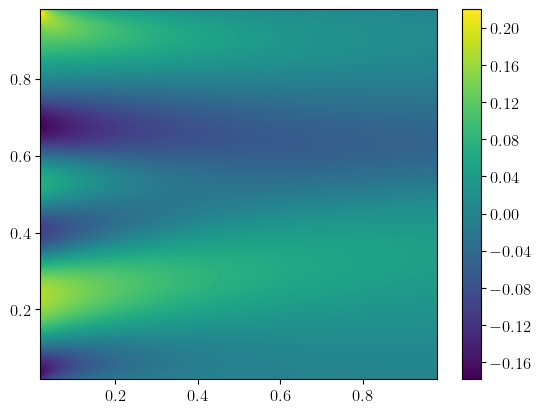

In [262]:
plt.tricontourf(*tx_fine_int.T,ut_true_function(tx_fine_int),200)
plt.colorbar()
plt.show()

In [263]:
# Estimated P from 1.5 step method
input_features = EqnModel.get_stacked_eqn_features((u_sol,)) # before
# input_features = EqnModel.single_eqn_features(u_model,u_sol,tx_all) # now
Phat = lambda x: P_model.predict_new(x,input_features,P_sol)

# In-sample

# P[\phi(w)](fine_grid)
def evaluate_Phat(Phat, interp, fine_grid):

    # Build S_test
    def u_true_function(x):
        return interp(x[:,0],x[:,1],grid = False)
    def ux_true_function(x):
        ux_interp = interp.partial_derivative(0,1)
        return ux_interp(x[:,0],x[:,1],grid = False)
    def uxx_true_function(x):
        uxx_interp = interp.partial_derivative(0,2)
        return uxx_interp(x[:,0],x[:,1],grid = False)
    
    # By hand since the truth is taken as interp from scipy and not an induced RKHS class where we can apply usual feature operators
    feat_funcs = [u_true_function, ux_true_function, uxx_true_function]
    w_features = jnp.array([feat_func(fine_grid) for feat_func in feat_funcs]).T
    fine_features = jnp.hstack([fine_grid, w_features])
    S_test = fine_features
    
    P_preds = Phat(S_test)
    return P_preds

In [264]:
Phat_u = evaluate_Phat(Phat, interp, tx_fine_int)
u_t = ut_true_function(tx_fine_int)

Relative error:  0.11225544706398845


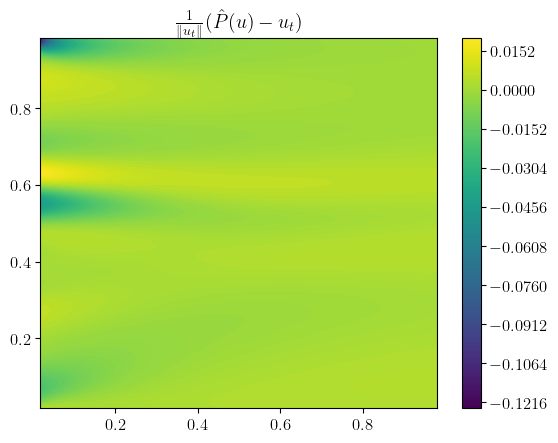

In [265]:
plt.tricontourf(*tx_fine_int.T, (Phat_u - u_t)/ jnp.linalg.norm(u_t),200)
plt.title(r'$\frac{1}{\|u_t\|}(\hat{P}(u)-u_t)$')
plt.tricontourf(*tx_fine_int.T, (Phat_u - u_t),200)
plt.colorbar()
print('Relative error: ',jnp.linalg.norm(Phat_u - u_t,2) / jnp.linalg.norm(u_t,2))
# plt.title(r'$\hat{P}(u)-u_t$')
plt.show()

## PINNSR

In [279]:
def get_data_for_pinns(gamma,n_obs, n_coll_t, n_coll_x,run):
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = 1,
                                            X = xy_pts, 
                                            smooth = gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = run
                                        )
    vec_u0_true_function = np.vectorize(u0_true_function[0])
    
    # Solve m Burgers' equations with IC's: u0_true_functions 
    kappa = 0.01
    alpha = 1.


    u_true_function,ut_true_function, interp,_,_ = (
    build_burgers_data(func_u0=vec_u0_true_function,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
                        )

    # Collocation point set size
    num_grid_x = n_coll_x
    num_grid_t = n_coll_t
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    # Collocation point set

    # # Get (X^m, u^m(X^m))
    num_obs = n_obs
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs,
        jax.random.PRNGKey(run),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
    plot_input_data(
        tx_obs,
        tx_all,
        u_true_function,
        tx_fine,
                )
    # Invert them to be ready for PINNSR
    
    tx_train = tx_obs
    u_train = u_true_function(tx_train)
    tx_val = jax.random.choice(key = jax.random.PRNGKey(0), a = tx_fine, shape = (int(jnp.ceil(tx_train.shape[0]*(1-0.8)/0.8)),), replace=False)
    plt.scatter(*tx_val.T,c = 'green')
    u_val = u_true_function(tx_val)
    lb = tx_fine.min(0)
    ub = tx_fine.max(0)

    tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

    tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

    tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

    tx_all = jnp.vstack([tx_all,tx_train])

    return [tx_train, u_train, tx_all, tx_val, u_val, lb, ub]

  0%|          | 0/10099 [00:00<?, ?it/s]

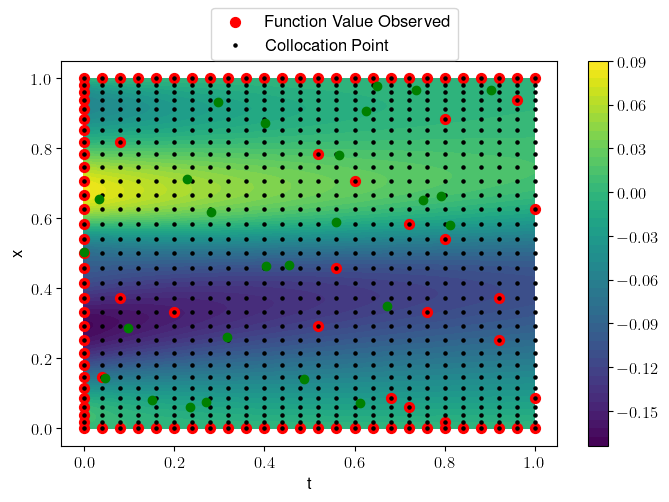

In [280]:
data_pinns = get_data_for_pinns(gamma=2,n_obs=20,n_coll_t=26, n_coll_x=31, run=2)

In [283]:
data_numpy = list(map(np.array,data_pinns))

In [284]:
np.save('data_test_pinn.npy', np.array(data_numpy, dtype=object), allow_pickle=True)

The equation recovered by PINNSR was:
```
u_t = -0.0136393011
-0.33108413u
+0.0043411828u**2
-0.039289325u_x
+0.33696544u*u_x
+0.026660636u**2*u_x
+0.005249514u_xx
-0.00819559u*u_xx
-0.08392856u**2*u_xx
```

In [285]:
# Estimated P
def u_true_function(x):
    return interp(x[:,0],x[:,1],grid = False)
def ux_true_function(x):
    ux_interp = interp.partial_derivative(0,1)
    return ux_interp(x[:,0],x[:,1],grid = False)
def uxx_true_function(x):
    uxx_interp = interp.partial_derivative(0,2)
    return uxx_interp(x[:,0],x[:,1],grid = False)

fine_grid = tx_fine_int
U = u_true_function(fine_grid)
U_x = ux_true_function(fine_grid)
U_xx = uxx_true_function(fine_grid)

Phat_PINNSR = -0.0136393011-0.33108413*U+0.0043411828*jnp.multiply(U,U)-0.039289325*U_x+0.33696544*jnp.multiply(U,U_x)+0.026660636*jnp.multiply(jnp.multiply(U,U),U_x)+0.005249514*U_xx-0.00819559*jnp.multiply(U,U_xx)-0.08392856*jnp.multiply(jnp.multiply(U,U),U_xx)

Relative error:  0.38154099944734315


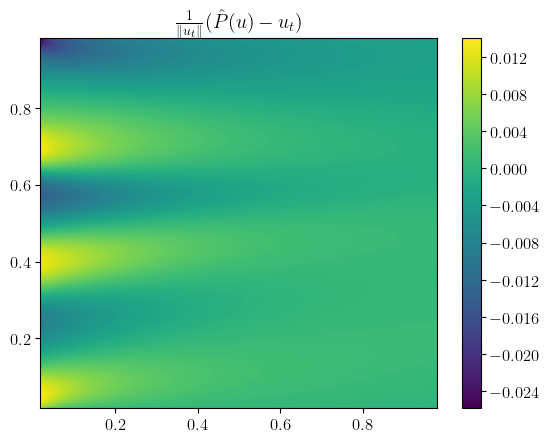

In [286]:
plt.tricontourf(*tx_fine_int.T, (Phat_PINNSR - u_t)/ jnp.linalg.norm(u_t),200)
plt.title(r'$\frac{1}{\|u_t\|}(\hat{P}(u)-u_t)$')
# plt.tricontourf(*tx_test.T, (Phat_PINNSR - u_t),200)
plt.colorbar()
print('Relative error: ',jnp.linalg.norm(Phat_PINNSR - u_t,2) / jnp.linalg.norm(u_t,2))
# plt.title(r'$\hat{P}(u)-u_t$')
plt.show()